In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pydicom


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.3 MB/s eta 0:00:00


In [16]:
import os
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random
import cv2
import numpy as np
import os
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random


In [7]:


# Ruta a los directorios de datos
train_dir = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/train'
test_dir = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/test'
train_csv = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/train.csv'
sample_submission_csv = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/sample_submission.csv'

# Cargar los datos de entrenamiento
train_df = pd.read_csv(train_csv)

# Visualizar algunas filas del DataFrame
train_df.head()


,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10062189329714053601...,14
1,1.2.826.0.1.3680043.8.498.53411283183733547704...,3
2,1.2.826.0.1.3680043.8.498.12955484645689261949...,3
3,1.2.826.0.1.3680043.8.498.10408703585974384892...,3
4,1.2.826.0.1.3680043.8.498.30255106562321206269...,9


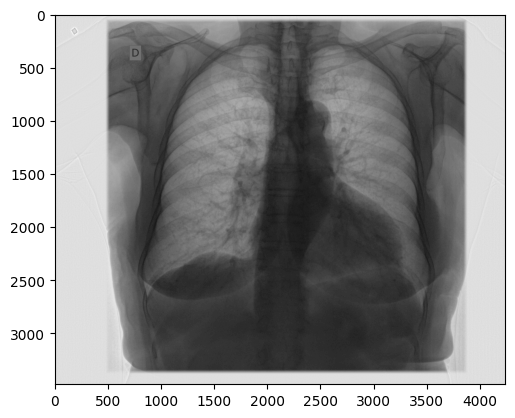

In [15]:
def show_dicom_image_single(file_path):
    dicom = pydicom.dcmread(file_path)
    plt.imshow(dicom.pixel_array, cmap='gray')
    plt.show()

# Mostrar una imagen de ejemplo
example_image_path = os.path.join(train_dir, train_df.iloc[2]['SOPInstanceUID'] + '.dcm')
show_dicom_image_single(example_image_path)


/usr/local/lib/python3.10/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (15-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


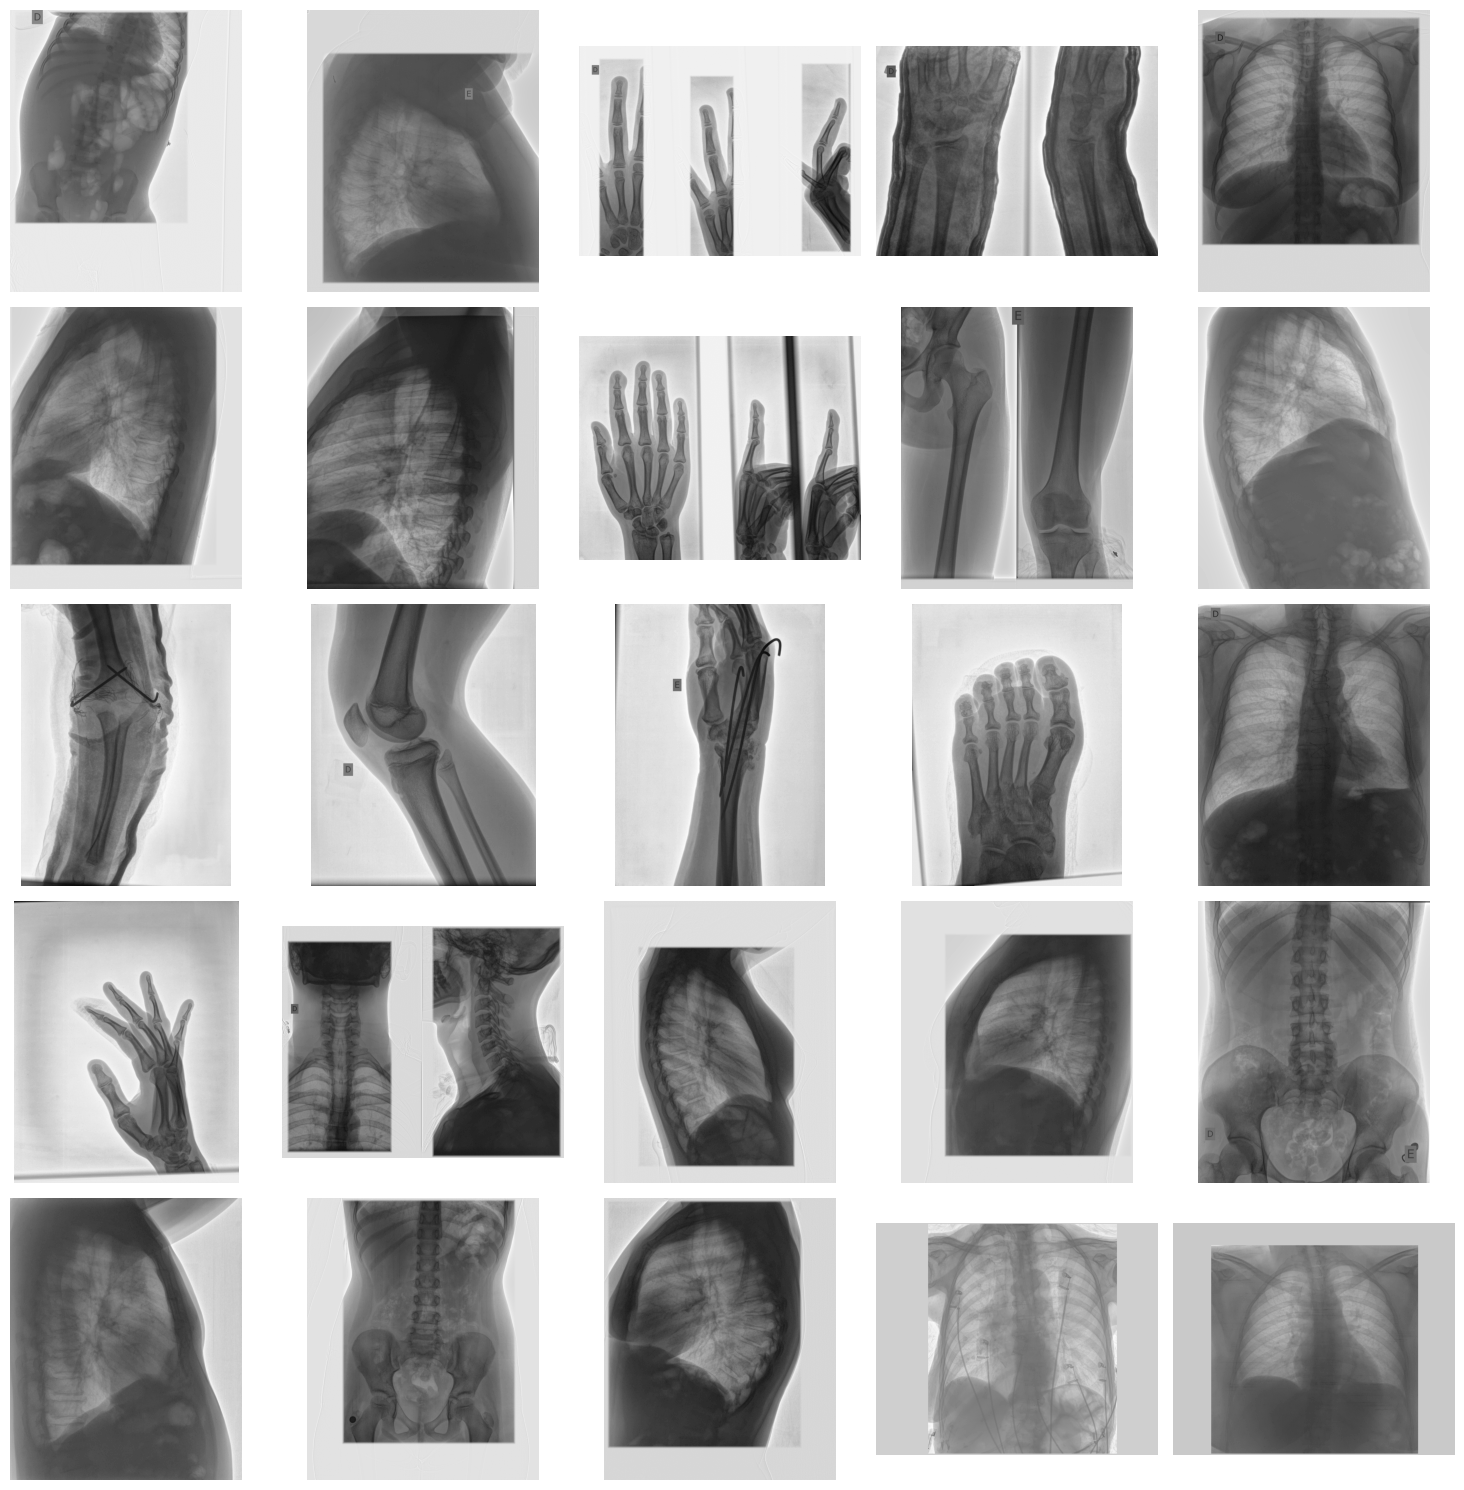

In [14]:
def show_dicom_image_multi(file_path, ax):
    dicom = pydicom.dcmread(file_path)
    ax.imshow(dicom.pixel_array, cmap='gray')
    ax.axis('off')  # Desactivar ejes

# Seleccionar 25 imágenes al azar
random_indices = random.sample(range(len(train_df)), 25)
random_image_paths = [os.path.join(train_dir, train_df.iloc[i]['SOPInstanceUID'] + '.dcm') for i in random_indices]

# Crear una figura y ejes para una matriz de 5x5
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# Mostrar cada imagen en su correspondiente subgráfico
for ax, image_path in zip(axes.flat, random_image_paths):
    show_dicom_image_multi(image_path, ax)

# Ajustar el espacio entre subgráficos
plt.tight_layout()
plt.show()
